In [8]:
import pybedtools as pbt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import treeswift as ts
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import re
import logomaker as lm
from collections import defaultdict
import numpy as np
from os.path import exists
import random
import sys

from matplotlib import cm

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [9]:
taxdict = {}
taxonomy_tree = ts.read_tree_newick('../data/metazoan_taxonomy.nwk')
tax_groups = ['Ctenophora', 
             'Hemichordata', 
             'Bryozoa', 
             'Rotifera', 
             'Chordata', 
             'Echinodermata', 
             'Arthropoda', 
             'Mollusca', 
             'Annelida', 
             'Nematoda', 
             'Platyhelminthes',
             'Cnidaria']

for tax in tax_groups:
    for node in taxonomy_tree.root.traverse_bfs():
        if node[0].label.strip("'") == tax:
            for i in node[0].traverse_leaves():
                taxdict[i.label.strip("'").replace(' ', '_')] = tax 
                

metadata_df = pd.read_csv('../data/parsed_metazoans.out', 
                          sep='\t', 
                          header=None, 
                          names=['species', 'genome', 'ftpdir', 'scaffold_n50', 'assembly_status']) \
                .drop(['ftpdir', 'genome'], axis=1)
metadata_df['genus'] = metadata_df['species'].apply(lambda x: x.split('_')[0])
metadata_df['taxonomy'] = metadata_df.species.apply(lambda x: taxdict.get(x, 'Other'))
print(metadata_df.head())

                 species  scaffold_n50 assembly_status         genus  \
0     Abisara_bifasciata           464          Contig       Abisara   
1   Abrostola_tripartita      13645312      Chromosome     Abrostola   
2  Abscondita_terminalis       1220005        Scaffold    Abscondita   
3     Acanthaster_planci       1521119        Scaffold   Acanthaster   
4   Acanthisitta_chloris         64469        Scaffold  Acanthisitta   

        taxonomy  
0          Other  
1     Arthropoda  
2     Arthropoda  
3  Echinodermata  
4       Chordata  


In [10]:
def extract_znf(species):
    znfs = []
    for record in SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'):
        seq = record.seq
        trim = len(seq)%3
        if trim == 0: 
            seq = str(seq.translate())
        else:
            seq = str(seq[:-trim].translate())        
        znfs += re.findall('C..C.{12}H...H', seq)
    return znfs

def extract_footprints(species):
    footprints = []
    for record in SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'):
        seq = record.seq
        trim = len(seq)%3
        if trim == 0: 
            seq = str(seq.translate())
        else:
            seq = str(seq[:-trim].translate())
        footprints += re.findall('C..C.{12}H...H', seq)
    footprints = [f'{i[9]}{i[11]}{i[12]}{i[15]}' for i in footprints]
    return footprints

def entropy(position):
    return -sum(position.apply(lambda x: x*np.log2(x)))

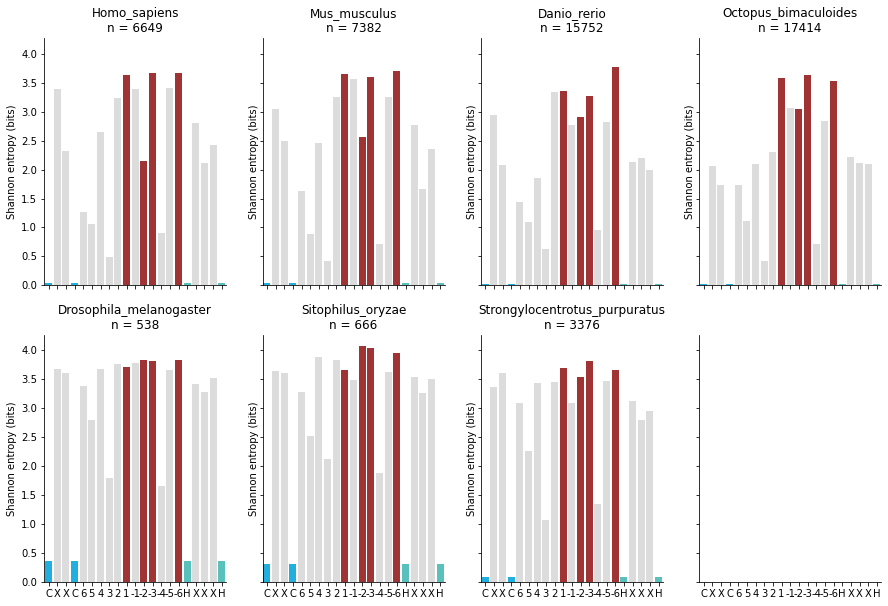

In [11]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=4, nrows=2, sharex=True, sharey=True)
i, j = 0, 0
for species in ['Homo_sapiens', 'Mus_musculus', 'Danio_rerio', 'Octopus_bimaculoides', 
                'Drosophila_melanogaster', 'Sitophilus_oryzae', 'Strongylocentrotus_purpuratus']:    
    if j > 3:
        i += 1
        j = 0
    znfs = []
    for row in metadata_df.loc[metadata_df.species == species].iterrows():
        znfs += extract_znf(row[1].species)
    # print(species, len(znfs))
    # znfs = np.random.choice(znfs, 500, replace=False)
    mat_df = lm.alignment_to_matrix(znfs, to_type='probability').T
    data = defaultdict(list)
    for col in mat_df.columns:
        data['position'].append(col)
        data['entropy'].append(entropy(mat_df[col]))

    znf_df = pd.DataFrame(data)
    znf_df['pos_labels'] = ['C', 'X', 'X', 'C', 6, 5, 4, 3, 2, 1, -1, -2, -3, -4, -5, -6, 'H', 'X', 'X', 'X', 'H']
    znf_df['colours'] = ['deepskyblue', 'gainsboro', 'gainsboro', 'deepskyblue', 
                         'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'firebrick',
                         'gainsboro', 'firebrick', 'firebrick', 'gainsboro', 'gainsboro', 'firebrick',
                         'mediumturquoise', 'gainsboro', 'gainsboro', 'gainsboro', 'mediumturquoise'] 

    sns.barplot(data=znf_df, x='position', y='entropy', palette=znf_df.colours, ax=axes[i][j])
    axes[i][j].set_title(f'{species}\nn = {len(znfs)}')
    axes[i][j].set_ylabel('Shannon entropy (bits)')
    axes[i][j].set_xticklabels(znf_df.pos_labels)
    axes[i][j].set_xlabel('')
    j += 1
sns.despine()
plt.show()
fig.savefig('../figs/species_znf_entropy.pdf', bbox_inches='tight')



In [12]:
fp_freq = defaultdict(int)
all_fps = extract_footprints('Danio_rerio')
for fp in all_fps:
    fp_freq[fp] += 1

In [13]:
motif_dict = {}
with open('../data/binding-predictions/GSE78099_RAW/imbeault_motifs.meme') as infile:
    for line in infile:
        if line.startswith('MOTIF'):
            line = line.split()
            motif_dict[line[1]] = line[2]

with open('../data/Genomes/Homo_sapiens_chr2acc.txt') as infile:
    infile.readline()
    chr2acc = {i.split()[1]: i.split()[2] for i in infile}

def rename_chrom(feature):
    feature.chrom = chr2acc.get(feature.chrom, feature.chrom)
    return feature

a = pbt.BedTool('/Users/jonwells/Genomes/Mammalia/GCF_000001405.39_GRCh38.p13_genomic.cds.gff').each(rename_chrom)
b = pbt.BedTool('../data/beds/Homo_sapiens_znfs.bed')
c = b.intersect(a, wa=True, wb=True, s=True)
znf_labels = defaultdict(list)
for interval in c:
    label = f'{interval.chrom}_{interval.start}-{interval.stop}({interval.strand})'
    znf_labels[label].append(re.search(';gene=(.+?);\w+', interval[14]).group(1))
for key, val in list(znf_labels.items()):
    znf_labels[key] = min(val, key=len)

In [14]:
def parse_tomtom(filename, shuffled=False):
    tp, fp = set(), set()
    if shuffled:
        with open('../data/binding-predictions/GSE78099_RAW/matched_predicted_motifs.shuffled.names') as infile:
            rnd_motifs = {i.split('\t')[0]: i.strip().split('\t')[-1] for i in infile}
    ttlab = []
    with open(filename) as infile:
        header = infile.readline().strip().split('\t')
        for line in infile:
            if '#' in line:
                continue
            line = line.strip().split('\t')
            if len(line) == 1:
                continue
            if shuffled:
                label = '_'.join(rnd_motifs[line[1]].split('_')[:2])
            else:
                label = '_'.join(line[1].split('_')[:2])
            newlabel = znf_labels.get(label, 'NA').strip('-rep2')
            if newlabel == 'NA':
                continue
            if float(line[5]) > 0.1:
                continue
            if motif_dict[line[0]] == newlabel:
                tp.add((motif_dict[line[0]], newlabel))
                print((motif_dict[line[0]], newlabel, line[1], line[5]))
            else:
                fp.add((motif_dict[line[0]], newlabel))
    return len(tp), len(fp)

truepos, falsepos = parse_tomtom('../data/binding-predictions/meme-out/Homo_sapiens/chipexo_vs_predicted/tomtom.tsv')
shuftruepos, shuffalsepos = parse_tomtom('../data/binding-predictions/meme-out/Homo_sapiens/chipexo_vs_shuffled/tomtom.tsv', True)

npredicted, nobserved = 281, 235 # Taken from counts of motif files.

# CHECK ME!!!!! (SEEMS WRONG!)
ntests = npredicted*nobserved
print()
print('all positive')
print(np.array([[truepos+falsepos, ntests-(truepos+falsepos)], 
                          [shuftruepos+shuffalsepos, ntests-(shuftruepos+shuffalsepos)]]))
print(stats.fisher_exact([[truepos+falsepos, ntests-(truepos+falsepos)], 
                          [shuftruepos+shuffalsepos, ntests-(shuftruepos+shuffalsepos)]]))
print()
print('True positive only')
print(np.array([[truepos, ntests-truepos], 
                          [shuftruepos, ntests-shuftruepos]]))
print(stats.fisher_exact([[truepos, ntests-truepos], 
                          [shuftruepos, ntests-shuftruepos]]))

('ZFP69', 'ZFP69', 'CM000663.2_40494898-40496056(+)_1|1|1x0', '0.0072603')
('ZNF879', 'ZNF879', 'CM000667.2_179032161-179033637(+)_1|1|1x0', '0.0628733')
('ZNF85', 'ZNF85', 'CM000681.2_20948652-20950299(+)_1|1|1x0', '1.54422e-06')
('ZNF311', 'ZNF311', 'CM000668.2_28995003-28996587(-)_1|1|1x0', '0.0649484')
('ZNF567', 'ZNF567', 'CM000681.2_36718910-36720665(+)_1|1|1x0', '1.78659e-06')
('ZNF248', 'ZNF248', 'CM000672.2_37831617-37833171(-)_1|1|1x0', '0.07414')
('ZNF880', 'ZNF880', 'CM000681.2_52383799-52385311(+)_1|1|1x0', '0.0215442')
('ZNF3', 'ZNF3', 'CM000669.2_100071145-100072297(-)_1|1|1x0', '0.00239802')
('ZNF266', 'ZNF266', 'CM000681.2_9413277-9414780(-)_1|1|1x0', '0.0477366')
('ZNF701', 'ZNF701', 'CM000681.2_52582170-52583454(+)_1|1|1x0', '0.0033376')
('ZNF320', 'ZNF320', 'CM000681.2_52880598-52882014(-)_1|1|1x0', '0.0550424')
('ZNF468', 'ZNF468', 'CM000681.2_52840727-52842182(-)_1|1|1x0', '0.00438643')
('ZNF483', 'ZNF483', 'CM000671.2_111541577-111543167(+)_1|1|1x0', '0.0195334')

In [15]:
def extract_ZiFRC_PFMs(motif_file):
    motif_dict = defaultdict(list)
    motif_flag = False
    with open(motif_file) as infile:
        for line in infile:
            if re.match('^Motif', line):
                motif = line.strip().split('\t')[1]
               # x print(motif)
            elif re.match('^Pos', line):
                motif_flag = True
            elif line == '\n':
                motif_flag = False
            if motif_flag == True:
                motif_dict[motif].append(line.strip().split('\t'))
            else:
                continue
    for key, val in list(motif_dict.items()):
        motif_dict[key] = lm.transform_matrix(pd.DataFrame(data=val[1:], 
                                                           columns=val[0], 
                                                           dtype=float).set_index('Pos'),
                                              from_type='probability', 
                                              to_type='information')
    return motif_dict

def extract_meme_PFMs(motif_file):
    motif_dict = defaultdict(list)
    motif_flag = False
    with open(motif_file) as infile:
        for line in infile:
            if re.match('^MOTIF', line):
                motif = line.strip().split()[2]
            elif re.match('^letter-probability matrix', line):
                motif_flag = True
            elif line == '\n':
                motif_flag = False
            if motif_flag == True:
                motif_dict[motif].append(line.strip().split())
            else:
                continue
    for key, val in list(motif_dict.items()):
        motif_dict[key] = lm.transform_matrix(pd.DataFrame(data=val[1:], 
                                                           columns=['A', 'C', 'G', 'T'], 
                                                           dtype=float),
                                              from_type='probability', 
                                              to_type='information')
    return motif_dict

def pad_logo(pad):
    return pd.DataFrame(data=[[0.0, 0.0, 0.0, 0.0]]*pad,
                        columns=['A', 'C', 'G', 'T'])

def generate_seqlogo(seq):
    seq = seq.upper()
    alphabet=['A', 'C', 'G', 'T']
    data = []
    for char in seq:
        probs = []
        for nuc in alphabet:
            if char == nuc:
                probs.append(1.0)
            else:
                probs.append(0.0)
        data.append(probs)
    return pd.DataFrame(data=data,
                        columns=alphabet)
            

predicted_human = extract_ZiFRC_PFMs('../data/binding-predictions/Homo_sapiens/results.PFM.txt')
observed_human = extract_meme_PFMs('../data/binding-predictions/GSE78099_RAW/imbeault_motifs.meme')
predicted_zebrafish = extract_ZiFRC_PFMs('../data/binding-predictions/Danio_rerio/results.PFM.txt')

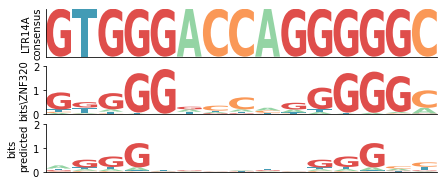

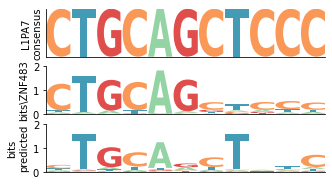

In [16]:
# ZNF320 -> LTR14A

obs_znf = observed_human['ZNF320']
pred_znf = pd.concat([pad_logo(2), predicted_human['CM000681.2_52880598-52882014(-)_1|1|1x0']]).reset_index(drop=True)[4:19]
bound_seq = generate_seqlogo('GAAAGTGGGACCAGGGGGCCATCGCGAGT')

palette = dict(zip(['G', 'C', 'A', 'T'],
                   [cm.colors.rgb2hex(c) for c in cm.get_cmap('Spectral', 16)([2, 4, 11, 13])]))

fig, axes = plt.subplots(figsize=(7, 3), nrows=3, sharex=True, sharey=False)
lm.Logo(bound_seq, color_scheme=palette, ax=axes[0])
lm.Logo(obs_znf, color_scheme=palette, ax=axes[1])
lm.Logo(pred_znf, color_scheme=palette, ax=axes[2])

axes[0].set_yticks([])
axes[0].set_yticklabels([])

axes[1].set_yticks([0, 1, 2])
axes[2].set_yticks([0, 1, 2])

axes[0].set_ylabel('LTR14A\nconsensus')
axes[1].set_ylabel('bits\ZNF320')
axes[2].set_ylabel('bits\npredicted')

axes[2].set_xticks([])
axes[2].set_xticklabels([])

sns.despine()
fig.savefig('../figs/human_znf320_ltr14a.pdf', bbox_inches='tight')
plt.show()

# ZNF83 -> L1PA7

obs_znf = pd.concat([pad_logo(7), observed_human['ZNF483']]).reset_index(drop=True)
pred_znf = predicted_human['CM000671.2_111541577-111543167(+)_1|1|1x0'][14:24]
bound_seq = pd.concat([pad_logo(14), generate_seqlogo('ctgcagctccc')]).reset_index(drop=True)

fig, axes = plt.subplots(figsize=(5, 3), nrows=3, sharex=True, sharey=False)
lm.Logo(bound_seq, color_scheme=palette, ax=axes[0])
lm.Logo(obs_znf, color_scheme=palette, ax=axes[1])
lm.Logo(pred_znf, color_scheme=palette, ax=axes[2])

axes[0].set_yticks([])
axes[0].set_yticklabels([])

axes[1].set_yticks([0, 1, 2])
axes[2].set_yticks([0, 1, 2])

axes[0].set_ylabel('L1PA7\nconsensus')
axes[1].set_ylabel('bits\ZNF483')
axes[2].set_ylabel('bits\npredicted')

axes[2].set_xticks([])
axes[2].set_xticklabels([])

sns.despine()
fig.savefig('../figs/human_znf483_l1pa7.pdf', bbox_inches='tight')
plt.show()

These results tell us that, at least in humans, there is clearly a significant enrichment of true positive matches between predicted and observed zinc finger binding motifs when compared against a control group of shuffled predicted motifs. Notably, there is also an enrichment of "false positive" matches, which likely reflects the fact that many human ZNFs are closely related to eachother and presumably have partially redundant binding preferences. With these results in hand, we can assume that predicted binding motifs do, at least to some degree, capture the true binding specificities of ZnFs in vivo. We therefore predicted binding motifs for a variety of other species, and tested whether there is an enrichment of predicted binding motifs in TE sequence versus either shuffled sequences or randomly selected genomic intervals.

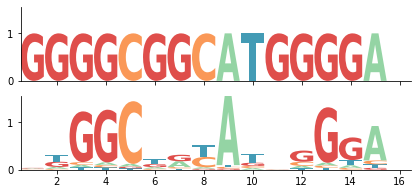

In [17]:
te, znf = ('ggggcggcatggggag', 'CM002906.2_1793167-1794271(+)_1|2|1x0')
bound_seq = pd.concat([pad_logo(1), generate_seqlogo(te)]).reset_index(drop=True)[:-1]
pred_znf = predicted_zebrafish[znf]

fig, axes = plt.subplots(figsize=(7, 3), nrows=2, sharex=True, sharey=True)
lm.Logo(bound_seq, color_scheme=palette, ax=axes[0])
lm.Logo(pred_znf, color_scheme=palette, ax=axes[1])

sns.despine()
plt.show()

['motif_id', 'motif_alt_id', 'sequence_name', 'start', 'stop', 'strand', 'score', 'p-value', 'q-value', 'matched_sequence']


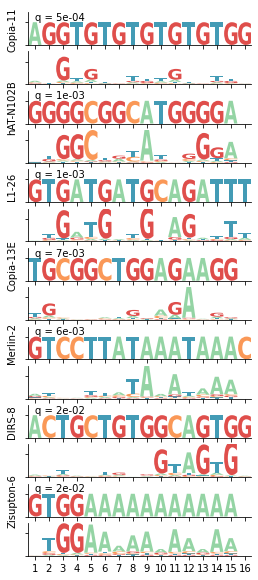

In [18]:
fig, axes = plt.subplots(figsize=(4, 10), nrows=14, sharex=True, sharey=True)
used_finz = []
used_tes = []
axes[0].set_xticks([i for i in range(1,17)])
with open('../data/binding-predictions/meme-out/Danio_rerio/predicted_vs_te/fimo.tsv') as infile:
    header = infile.readline().strip().split('\t')
    print(header)
    c, i = 0, 0
    for line in infile:
        if c >= 7:
            break
        line = line.strip().split('\t')
        znf, telabel, qvalue, te = line[0], line[2], line[-2], line[-1]
        
        if len(te) > 21:
            continue

        if znf in used_finz:
            continue
        else:
            used_finz.append(znf)
        if te in used_tes:
            continue
        else:
            used_tes.append(te)
        c += 1
        bound_seq = pd.concat([pad_logo(1), generate_seqlogo(te)]).reset_index(drop=True)[:-1]
        pred_znf = predicted_zebrafish[znf]
        lm.Logo(bound_seq, color_scheme=palette, ax=axes[i])
        axes[i].set_ylabel(telabel.rstrip('-I').rstrip('-LTR').rstrip('_DR'))
        axes[i].set_yticklabels([])
        axes[i].text(x=1, y=1.1, s=f'q = {float(qvalue):.0e}')
        i += 1
        lm.Logo(pred_znf, color_scheme=palette, ax=axes[i])
        i += 1
sns.despine()        
plt.show()
fig.savefig('../figs/danio_te_binding.pdf', bbox_inches='tight')

In [19]:
def triplet_diversity(seq):
    trips = [seq[i:i+3] for i in range(0, len(seq)+1, 3)]
    return len(set(trips))/len(trips)

def parse_fimo(filename, qthresh=0.05):
    pairs = set()
    with open(filename) as infile:
        infile.readline()
        for line in infile:
            if line.startswith('#'):
                continue
            line = line.strip().split('\t')
            if len(line) != 10:
                continue
            if float(line[8]) > qthresh:
                continue
            if triplet_diversity(line[9]) < 0.5:
                continue
            pairs.add((line[0], line[2]))
            
    return pairs

def calc_fisher(species, fimopairs, shuffledfimopairs):
    rmodeller_dict = {'Danio_rerio': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Danio_rerio_nosat.fa',
                      'Mus_musculus': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Mus_musculus_nosat.fa',
                      'Homo_sapiens': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Homo_sapiens_nosat.fa',
                      'Octopus_sinensis': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Octopus_sinensis_nosat.fa',
                      'Sitophilus_oryzae': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Sitophilus_oryzae_nosat.fa',
                      'Drosophila_melanogaster':'/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Drosophila_melanogaster_nosat.fa',
                      'Strongylocentrotus_purpuratus':'/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Strongylocentrotus_purpuratus_nosat.fa'}
    nfams = 0
    for rec in SeqIO.parse(rmodeller_dict[species], 'fasta'):
        nfams += 1
    bound_obs = len(set(i[1] for i in fimopairs))
    unbound_obs = nfams - bound_obs
    bound_shuf = len(set(i[1] for i in shuffledfimopairs))
    unbound_shuf = nfams - bound_shuf 
    data = pd.DataFrame([['TE sequence', bound_obs, unbound_obs], 
                         ['Non-repetitive', bound_shuf, unbound_shuf]],
                        columns=[f'{species}', 'matched', 'unmatched']).set_index(f'{species}')
    return data, stats.fisher_exact(data)

def calc_fraction(species, fimopairs, shuffledfimopairs, shuffled=False):
    rmodeller_dict = {'Danio_rerio': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Danio_rerio_nosat.fa',
                      'Mus_musculus': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Mus_musculus_nosat.fa',
                      'Homo_sapiens': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Homo_sapiens_nosat.fa',
                      'Octopus_sinensis': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Octopus_sinensis_nosat.fa',
                      'Sitophilus_oryzae': '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Sitophilus_oryzae_nosat.fa',
                      'Drosophila_melanogaster':'/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Drosophila_melanogaster_nosat.fa',
                      'Strongylocentrotus_purpuratus':'/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Strongylocentrotus_purpuratus_nosat.fa'}
    nfams = 0
    for rec in SeqIO.parse(rmodeller_dict[species], 'fasta'):
        nfams += 1
    bound_obs = len(set(i[1] for i in fimopairs))
    bound_shuf = len(set(i[1] for i in shuffledfimopairs))
    
    bound_frac_obs = 100*bound_obs/nfams
    bound_frac_shuf = 100*bound_shuf/nfams
    if shuffled:
        data = pd.DataFrame([[species, 'TE sequence', bound_frac_obs, bound_obs, nfams], 
                             [species, 'Shuffled', bound_frac_shuf, bound_shuf, nfams]],
                             columns=['species', 'library_type', 'bound_fraction', 'bound', 'nfams'])
    else:
        data = pd.DataFrame([[species, 'TE sequence', bound_frac_obs, bound_obs, nfams], 
                             [species, 'Non-repetitive', bound_frac_shuf, bound_obs, nfams]],
                             columns=['species', 'library_type', 'bound_fraction', 'bound', 'nfams'])
    return data

In [20]:
dfs = []
dfs2 = []
for species in ['Homo_sapiens', 
                'Mus_musculus', 
                'Danio_rerio', 
                'Octopus_sinensis', 
                'Drosophila_melanogaster', 
                'Sitophilus_oryzae',
                'Strongylocentrotus_purpuratus']:


    predicted_file = f'../data/binding-predictions/meme-out/{species}/predicted_vs_te/fimo.tsv'
    fimopairs = parse_fimo(predicted_file)
    shuffled_file = f'../data/binding-predictions/meme-out/{species}/predicted_vs_nonrep/fimo.tsv'
    shuffled_file2 = f'../data/binding-predictions/meme-out/{species}/shuffled_vs_te/fimo.tsv'
    shuffledfimopairs = parse_fimo(shuffled_file)
    shuffledfimopairs2 = parse_fimo(shuffled_file2)
    dfs.append(calc_fraction(species, fimopairs, shuffledfimopairs))
    dfs2.append(calc_fraction(species, fimopairs, shuffledfimopairs2, True))
binding_frac_df = pd.concat(dfs)
binding_frac_df2 = pd.concat(dfs2)
binding_frac_df = pd.concat([binding_frac_df, binding_frac_df2.loc[binding_frac_df2.library_type == 'Shuffled']])
print(binding_frac_df)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/Homo_sapiens_nosat.fa'

NameError: name 'binding_frac_df' is not defined

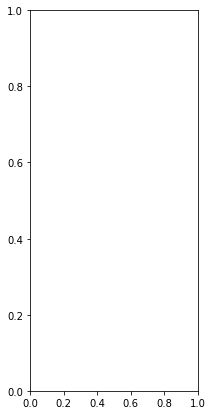

In [27]:
fig, ax = plt.subplots(figsize=(3, 7))
sns.barplot(data=binding_frac_df, 
            x='bound_fraction', 
            y='species', 
            hue='library_type',
            palette='PuBuGn', 
            linewidth=1, 
            edgecolor=".2",
            ax=ax)

for i, species in enumerate(binding_frac_df.loc[binding_frac_df.library_type == 'TE sequence', 'species']):
    base_prob = float(binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'Non-repetitive'), 'bound_fraction']/100)
    nfams = int(binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'Non-repetitive'), 'nfams'])
    bound = int(binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'TE sequence'), 'bound'])
    p = stats.binom_test(n=nfams, x=bound, p=base_prob, alternative='greater')
    if p < 0.01:
        ax.text(x=binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'TE sequence'), 'bound_fraction'] + 5,
                y=i+0.05,
                s=f'p = {p:.1e}') 
    else:
        ax.text(x=binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'TE sequence'), 'bound_fraction'] + 5,
                y=i+0.05,
                s=f'n.s.') 
    ax.text(x=1,
            y=i-0.2,
            s=f'{nfams}') 
    
for i, species in enumerate(binding_frac_df.loc[binding_frac_df.library_type == 'TE sequence', 'species']):
    base_prob = float(binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'Shuffled'), 'bound_fraction']/100)
    nfams = int(binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'Shuffled'), 'nfams'])
    bound = int(binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'TE sequence'), 'bound'])
    p = stats.binom_test(n=nfams, x=bound, p=base_prob, alternative='greater')
    if p < 0.01:
        ax.text(x=binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'TE sequence'), 'bound_fraction'] + 5,
                y=i+0.6-0.25,
                s=f'p = {p:.1e}') 
    else:
        ax.text(x=binding_frac_df.loc[(binding_frac_df.species == species) & (binding_frac_df.library_type == 'TE sequence'), 'bound_fraction'] + 5,
                y=i+0.6-0.25,
                s=f'n.s.') 
    
    

ax.set_ylabel('')
ax.set_xlabel('Sequences targeted (%)')
ax.set_xticklabels([0, 20, 40, 60, 80, 100])
ax.set_yticklabels([i._text.split('_')[0][0] + '. ' + i._text.split('_')[1] for i in list(ax.get_yticklabels())])
sns.despine()
fig.savefig('../figs/znf_motif_binding.pdf', bbox_inches='tight')
plt.show()

In [22]:
print(binding_frac_df)
print(len(binding_frac_df))

NameError: name 'binding_frac_df' is not defined

What about the age of TEs? Are Octopus and Danio TEs younger? Does this explain the higher number of matched ZnFs?

   teclass  count    extype  replicate
0      LTR    434  observed          1
1     LINE    149  observed          1
2      DNA    234  observed          1
0     LINE    139  expected          0
1      DNA    385  expected          0
..     ...    ...       ...        ...
1     LINE    154  expected        999
2      DNA    376  expected        999
0      LTR    339  expected       1000
1      DNA    378  expected       1000
2     LINE    137  expected       1000

[3006 rows x 4 columns]
LTR 0.0
DNA 1.0
LINE 0.039


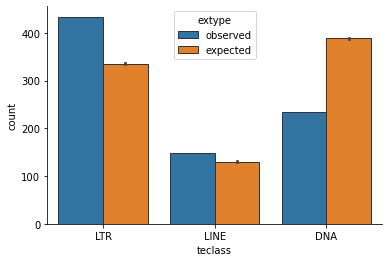

In [31]:
def parse_danio_telib(species):
    df = pd.read_csv('/Users/jonwells/Projects/feschottelab/drerio-tes/data/repeatmasker-out/parserm/danRer11.nonalt.fa.align.parseRM.all-repeats.tab',
                     sep='\t')
        
    df = df.loc[df.Rclass.isin(['DNA', 'LTR', 'LINE'])][['#Rname', 'Rclass', 'Rfam', 'AVG_%DIV']]
    return df

te_df = parse_danio_telib('Danio')
predicted_file = f'../data/binding-predictions/meme-out/Danio_rerio/shuffled_vs_te/fimo.tsv'
pairs = parse_fimo(predicted_file)

obs = defaultdict(int)
teclass_dict = {i[1]['#Rname']: i[1]['Rclass'] for i in te_df.iterrows()}
pred_dfs = [] 
for i in range(0, 1001):
    pred = defaultdict(int)
    for pair in pairs:
        pred[np.random.choice(te_df['Rclass'])] += 1
    pred_df = pd.DataFrame.from_dict(pred, orient='index').reset_index().rename({'index': 'teclass', 0: 'count'}, axis=1)
    pred_df['extype'] = 'expected'
    pred_df['replicate'] = i
    pred_dfs.append(pred_df)
     
for pair in pairs:
    obs[teclass_dict.get(pair[1], 'NA')] += 1
obs_df = pd.DataFrame.from_dict(obs, orient='index').reset_index().rename({'index': 'teclass', 0: 'count'}, axis=1)
obs_df['extype'] = 'observed'
obs_df['replicate'] = 1

pred_dfs = [obs_df] + pred_dfs
teclass_df = pd.concat(pred_dfs)
teclass_df = teclass_df.loc[teclass_df.teclass != 'NA']
print(teclass_df)

for te in ['LTR', 'DNA', 'LINE']:
    n = 0
    x = teclass_df.loc[(teclass_df.extype == 'observed') & (teclass_df.teclass == te), 'count']
    for rep in range(1, 1001):
        y = teclass_df.loc[(teclass_df.extype == 'expected') & (teclass_df.replicate == rep) & (teclass_df.teclass == te), 'count']
        if int(y) >= int(x):
            n += 1
    print(te, n/1000)
            

fig, ax = plt.subplots()
sns.barplot(data=teclass_df, 
            x='teclass', 
            y='count', 
            hue='extype',
            linewidth=1,
            edgecolor=".2")
sns.despine()
plt.show()

In [112]:

shuffled_df = pd.DataFrame(parse_fimo(f'../data/binding-predictions/meme-out/Danio_rerio/shuffled_vs_te/fimo.tsv'), 
                           columns = ['znf', 'tename'])
shuffled_df['exp_type'] = 'shuffled'
observed_df = pd.DataFrame(parse_fimo(f'../data/binding-predictions/meme-out/Danio_rerio/predicted_vs_te/fimo.tsv'),
                           columns = ['znf', 'tename'])
observed_df['exp_type'] = 'observed'
df = pd.concat([observed_df, shuffled_df])
df = df.merge(te_df[['#Rname', 'Rclass']], left_on='tename', right_on='#Rname') \
       .drop('#Rname', axis=1) \
       .drop('znf', axis=1) \
       .drop_duplicates() \
       .rename({'Rclass': 'teclass'}, axis=1) \
       .groupby(['teclass', 'exp_type']) \
       .count() \
       .reset_index()
# print(df)
df = df.pivot(index='teclass', columns='exp_type').tename.reset_index()
df['shuffled_proportion'] = df['shuffled']/sum(df.shuffled)
df['expected'] = df.shuffled_proportion*sum(df.observed)

print(stats.chisquare(df['observed'], df.expected))

Power_divergenceResult(statistic=66.25056288501001, pvalue=4.110295617849736e-15)


In [24]:
telen = {rec.name: len(rec.seq) for rec in SeqIO.parse('/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/zebrep.ref', 'fasta')}
tecount = defaultdict(int)
for p in pairs:
    tecount[p[1]] += 1

telen_df = pd.DataFrame([(te, teclass_dict.get(te, 'NA'), tecount.get(te, 0), telen[te]) for te in telen.keys()],
                        columns=['tename', 'teclass', 'tecount', 'telen'])
print(telen_df)

fig, ax = plt.subplots()
sns.boxplot(data=telen_df.loc[(telen_df.teclass.isin(['LTR', 'LINE', 'DNA'])) 
                              & (telen_df.tecount < 4)], x='tecount', y='telen', hue='teclass', notch=True)
ax.set_yscale('log')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonwells/Genomes/RepBase/RepBase26.10.fasta/zebrep.ref'

0       11.601432
1       11.778052
2       18.673138
3       21.790230
4       21.862331
          ...    
2938     8.804216
2939    11.449788
2940    14.966735
2941    17.499012
2942    17.530987
Name: AVG_%DIV, Length: 2943, dtype: float64


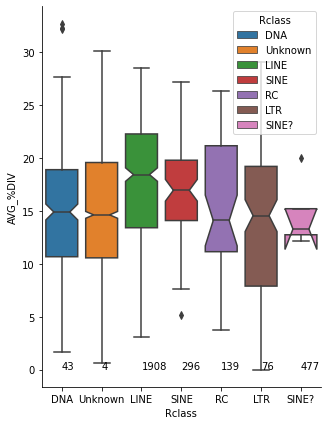

In [25]:
parserm_df = pd.read_csv('/Users/jonwells/Genomes/Mollusca/repeatmasker-out/GCF_006345805.1_ASM634580v1_genomic.fna.align.parseRM.all-repeats.tab',
                         sep='\t', na_values='nd')
fig, ax = plt.subplots(figsize=(5, 7))
print(parserm_df['AVG_%DIV'])
sns.boxplot(data=parserm_df,
            x='Rclass',
            y='AVG_%DIV',
            hue='Rclass', 
            dodge=False, 
            notch=True,
            ax=ax)
for i, teclass in enumerate(set(parserm_df.Rclass)):
    n=len(parserm_df.loc[parserm_df.Rclass == teclass, '#Rname'])
    ax.text(x=i, y=0, s=n)
sns.despine()
plt.show()

In [ ]:
print(stats.fisher_exact([[1622, 442], [102, 819]]))
print(stats.fisher_exact([[1622, 442], [102, 819]]))